In [1]:
using AlgebraicStockFlow

using Catlab
using Catlab.CategoricalAlgebra
using LabelledArrays
using OrdinaryDiffEq
using Plots

using Catlab.Graphics
using Catlab.Programs
using Catlab.WiringDiagrams

This model is re-created based on Garnett's paper:
https://journals.lww.com/stdjournal/Fulltext/2000/11000/Epidemiology_and_Control_of_Curable_Sexually.7.aspx

In [2]:
# define the function of new born
fNewBorn(u,uN,p,t)=uN.N(u,t)*p.μ
# define other functions of flows in this model, since all the other flows' functions have the 
# same form: up_stream stock * rate
# uS: name (symbol) of the upper stream stock
# r: name (symbol) of the parameter rate
function fLinear(uS,r)
    fL(u,uN,p,t) = u[uS]*p[r]
    return fL
end
# define the functions of new infectious flow
# I: the string of "A" or "Y"
function fInfectious(I)
    fIA(u,uN,p,t) = (1-p[:ϕ])*u.X*p[:cβ]*uN.NI(u,t)/uN.N(u,t)
    fIY(u,uN,p,t) = p[:ϕ]*u.X*p[:cβ]*uN.NI(u,t)/uN.N(u,t)
    if I=="A"
        return fIA
    else
        return fIY
    end
end
# define function of concatenate of two strings to symbol
# s1,s2: String
fsymbol(s1,s2)=Symbol(s1*s2)


fsymbol (generic function with 1 method)

# 1. Define the components of all the sub-models
## 1.1 The births and deaths of Stock X

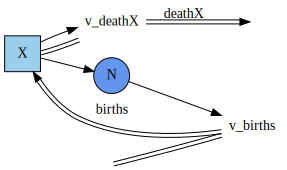

In [3]:
#(stock_name=>(inflows, outflows, variables, svariables))
     ## if a stock has no inflow or no outflow, use keyword ":F_NONE"
     ## if a stock has no variables connect to, use keyword ":V_NONE"
     ## if a stock has no sum_variables connect to, use keyword ":SV_NONE"
#(flow=>variable)
#(variable=>function)
#(svariable=>variable)
     ## if sum_variable contributes to no variables, use keywork ":SVV_NONE"
openX=Open(
    StockAndFlow(
    (:X=>(:births,:deathX,:v_deathX,:N)),
    (:births=>:v_births,:deathX=>:v_deathX),
    (:v_births=>fNewBorn,:v_deathX=>fLinear(:X,:μ)),
    (:N=>:v_births)
    ),
    # feet
    foot(:X,:N,:X=>:N)
)
Graph(apex(openX))

## 1.2 The SIS sub-model structure

In [4]:
#(stock_name=>(inflows, outflows, variables, svariables))
     ## if a stock has no inflow or no outflow, use keyword ":F_NONE"
     ## if a stock has no variables connect to, use keyword ":V_NONE"
     ## if a stock has no sum_variables connect to, use keyword ":SV_NONE"
#(flow=>variable)
#(variable=>function)
#(svariable=>variable)
     ## if sum_variable contributes to no variables, use keywork ":SVV_NONE"

# I: string of stock "A" or "Y"
# r: symbol of the constant parameter σ or σ′
# f: function of fInfectiousA or fInfectiousY
openSIS(I,r)=Open(
    StockAndFlow(
    (:X=>(fsymbol("recovery",I),fsymbol("newInfectious",I),fsymbol("v_newInfectious",I),:N),
     Symbol(I)=>(fsymbol("newInfectious",I),(fsymbol("death",I), fsymbol("recovery",I)),(fsymbol("v_death",I), fsymbol("v_recovery",I)),(:N,:NI))),
    (fsymbol("recovery",I)=>fsymbol("v_recovery",I),fsymbol("newInfectious",I)=>fsymbol("v_newInfectious",I),fsymbol("death",I)=>fsymbol("v_death",I)),
    (fsymbol("v_recovery",I)=>fLinear(Symbol(I),r),fsymbol("v_newInfectious",I)=>fInfectious(I),fsymbol("v_death",I)=>fLinear(Symbol(I),:μ)),
    (:N=>fsymbol("v_newInfectious",I), :NI=>fsymbol("v_newInfectious",I))
    ),
    # feet
    foot(:X,:N,:X=>:N),
    foot((),:NI,())
)


openSIS (generic function with 1 method)

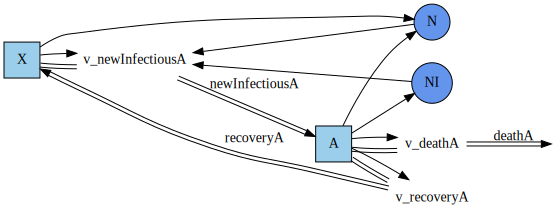

In [5]:
Graph(apex(openSIS("A",:σ′)))

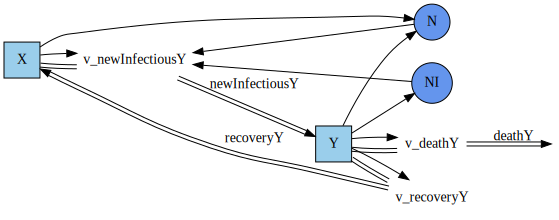

In [6]:
Graph(apex(openSIS("Y",:σ)))

# 2 Compose
## 2.1 Define composition rule

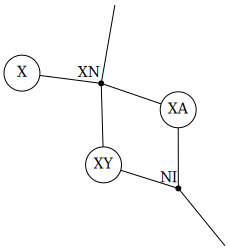

In [6]:
# define the UWD-algebra
uwd = @relation (XN,NI) begin
    X(XN)
    XA(XN,NI)
    XY(XN,NI)
end;
display_uwd(uwd)

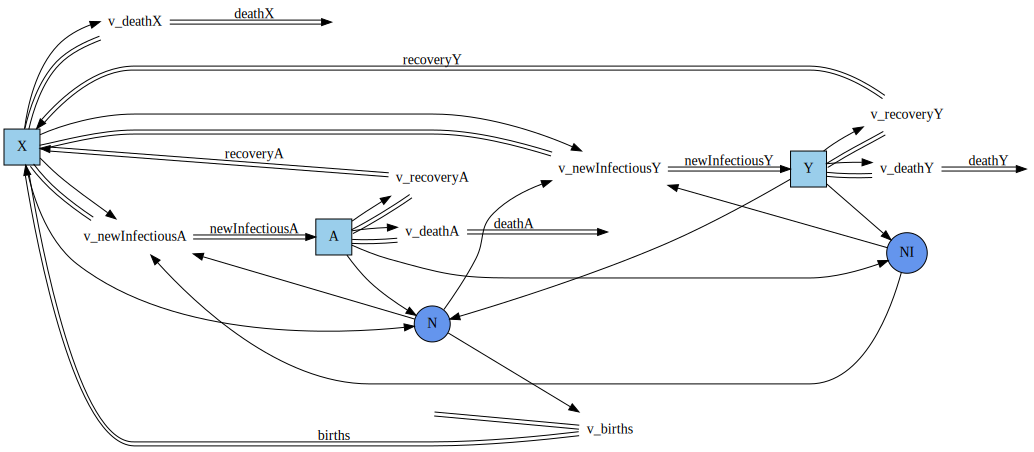

In [7]:
XAY_model = oapply(uwd,Dict(
    :X=>openX,
    :XA=>openSIS("A",:σ′),
    :XY=>openSIS("Y",:σ)
    )) |> apex
Graph(XAY_model)

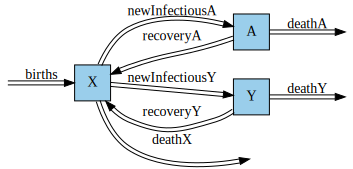

In [8]:
Graph(XAY_model,type="SF")

# 3. Solve ODEs

In [9]:
# define values of constant parameters
# unit: year
p = LVector(
    cβ=15*0.7, μ=1/15,ϕ=(0.95+0.4)/2,σ=12/4,σ′=12/4
)
# define initial values for stocks
u0 = LVector(
    X=990, A=5, Y=5
)

3-element LArray{Int64, 1, Vector{Int64}, (:X, :A, :Y)}:
 :X => 990
 :A => 5
 :Y => 5

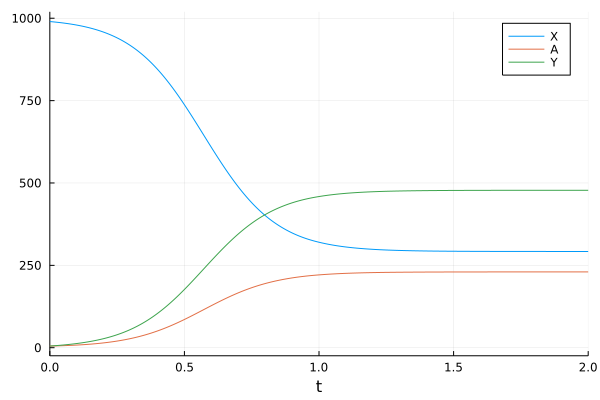

In [10]:
# results are tested the same as the Anylogic model
prob_XAY = ODEProblem(vectorfield(XAY_model),u0,(0.0,2.0),p);
sol = solve(prob_XAY,Tsit5(),abstol=1e-8);
plot(sol)

In [7]:
# to have the figures plotted fix to the wider of the cells
HTML("""
<style>
.output_svg div{
  width: 100% !important;
  height: 100% !important;
}
</style>
""")


HTML{String}("<style>\n.output_svg div{\n  width: 100% !important;\n  height: 100% !important;\n}\n</style>\n")